In [84]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [85]:
# Reading the data from HAM_metadata.csv
df = pd.read_csv(r"C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\input\HAM10000_metadata.csv")

In [86]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [87]:
df.dtypes


lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [88]:
df.describe

<bound method NDFrame.describe of          lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]>

In [89]:
df.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [90]:
# adding mean of age where the age is null 
df['age'].fillna(int(df['age'].mean()),inplace=True)


In [91]:
df.isnull().sum()


lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [92]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = r"C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\input\skin-cancer-mnist-ham10000"

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [93]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,2


Image Preprocessing

In [94]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 125))))

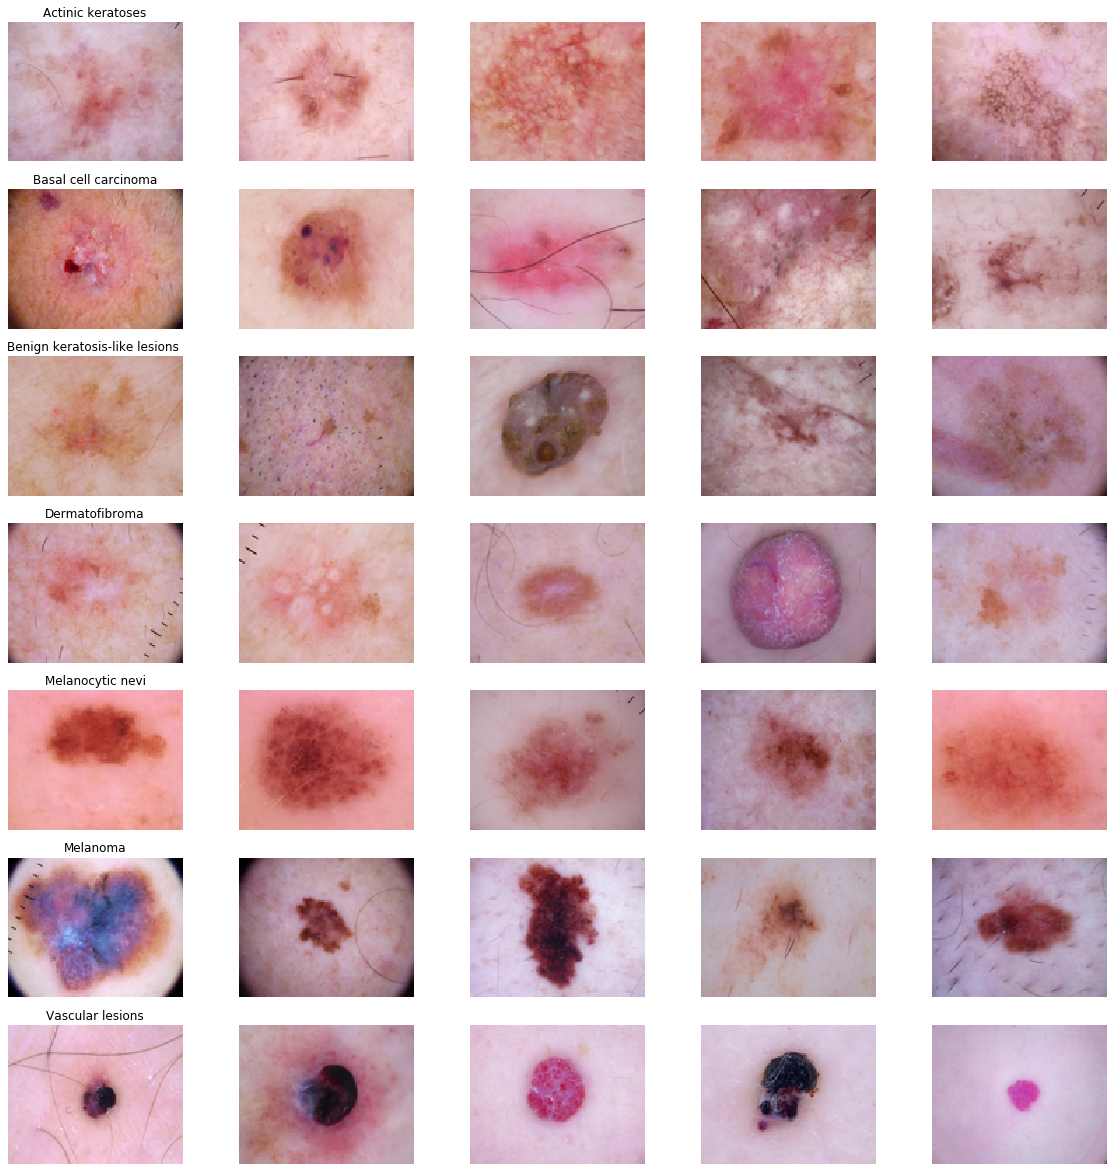

In [13]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

Simple Neural Network

In [14]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [15]:
features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,"[[[189, 152, 194], [192, 156, 198], [191, 154,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,"[[[24, 13, 22], [24, 14, 22], [24, 14, 26], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,"[[[186, 127, 135], [189, 133, 145], [192, 135,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,"[[[24, 11, 17], [24, 11, 20], [30, 15, 25], [4..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\msrip\Documents\GT\Fall 2021\CS 4641\...,Benign keratosis-like lesions,"[[[131, 88, 110], [142, 97, 120], [152, 107, 1..."


In [18]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0])>)

In [19]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [20]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [21]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
print(x_train.shape)
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
print(x_test.shape)
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
print(x_validate.shape)

(6759, 100, 125, 3)
(2504, 100, 125, 3)
(752, 100, 125, 3)


In [22]:
x_train = x_train.reshape(6759,125*100*3)
x_test = x_test.reshape(2504,125*100*3)
print(x_train.shape)
print(x_test.shape)

(6759, 37500)
(2504, 37500)


In [31]:
# define the keras model
model = Sequential()

model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 37500))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units= 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)
# compile the keras model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, batch_size = 10, epochs = 50)

accuracy = model.evaluate(x_test, y_test, verbose=1)[1]
print("Test: accuracy = ",accuracy*100,"%")

Epoch 1/50
676/676 [==============================] - 11s 15ms/step - loss: 0.9829 - accuracy: 0.6714
Epoch 2/50
676/676 [==============================] - 10s 15ms/step - loss: 0.8942 - accuracy: 0.6860
Epoch 3/50
676/676 [==============================] - 10s 15ms/step - loss: 0.8552 - accuracy: 0.6966
Epoch 4/50
676/676 [==============================] - 10s 15ms/step - loss: 0.8204 - accuracy: 0.7105
Epoch 5/50
676/676 [==============================] - 11s 16ms/step - loss: 0.7953 - accuracy: 0.71680s - loss: 0.7958 - accuracy: 0.71
Epoch 6/50
676/676 [==============================] - 12s 17ms/step - loss: 0.7626 - accuracy: 0.7276
Epoch 7/50
676/676 [==============================] - 11s 17ms/step - loss: 0.7378 - accuracy: 0.7361
Epoch 8/50
676/676 [==============================] - 12s 18ms/step - loss: 0.7178 - accuracy: 0.7401
Epoch 9/50
676/676 [==============================] - 13s 19ms/step - loss: 0.6836 - accuracy: 0.7460
Epoch 10/50
676/676 [===========================

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


CNN

In [54]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*3 -> Flatten -> Dense*2 -> Dropout -> Out
input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 100, 125, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 125, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 50, 62, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 62, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 62, 32)        9248      
                                                      

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00075,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = 1e-8)

In [43]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [44]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [45]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [45]:
# Fit the model
epochs = 60
batch_size = 16
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

from tensorflow.keras.metrics import Recall
from sklearn.metrics import classification_report,confusion_matrix

C:\Users\msrip\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/60
380/380 [==============================] - 235s 620ms/step - loss: 0.9227 - accuracy: 0.6758 - val_loss: 0.8967 - val_accuracy: 0.6553 - lr: 7.5000e-04
Epoch 2/60
380/380 [==============================] - 176s 464ms/step - loss: 0.9106 - accuracy: 0.6764 - val_loss: 0.9012 - val_accuracy: 0.6568 - lr: 7.5000e-04
Epoch 3/60
380/380 [==============================] - 187s 493ms/step - loss: 0.8759 - accuracy: 0.6881 - val_loss: 0.8873 - val_accuracy: 0.6598 - lr: 7.5000e-04
Epoch 4/60
380/380 [==============================] - 177s 466ms/step - loss: 0.8570 - accuracy: 0.6911 - val_loss: 0.9775 - val_accuracy: 0.6746 - lr: 7.5000e-04
Epoch 5/60
380/380 [==============================] - 174s 459ms/step - loss: 0.8388 - accuracy: 0.7023 - val_loss: 0.8669 - val_accuracy: 0.6834 - lr: 7.5000e-04
Epoch 6/60
380/380 [==============================] - 177s 466ms/step - loss: 0.8149 - accuracy: 0.7063 - val_loss: 0.8388 - val_accuracy: 0.6864 - lr: 7.5000e-04
Epoch 7/60
380/380 [==

Epoch 47/60
380/380 [==============================] - 180s 472ms/step - loss: 0.5140 - accuracy: 0.8040 - val_loss: 0.6414 - val_accuracy: 0.7648 - lr: 4.6875e-05
Epoch 48/60
380/380 [==============================] - 177s 464ms/step - loss: 0.5019 - accuracy: 0.8124 - val_loss: 0.6377 - val_accuracy: 0.7737 - lr: 4.6875e-05
Epoch 49/60
380/380 [==============================] - 176s 462ms/step - loss: 0.5164 - accuracy: 0.8080 - val_loss: 0.6413 - val_accuracy: 0.7692 - lr: 4.6875e-05
Epoch 50/60
380/380 [==============================] - ETA: 0s - loss: 0.5137 - accuracy: 0.8116
Epoch 00050: ReduceLROnPlateau reducing learning rate to 2.3437500203726813e-05.
380/380 [==============================] - 175s 461ms/step - loss: 0.5137 - accuracy: 0.8116 - val_loss: 0.6480 - val_accuracy: 0.7692 - lr: 4.6875e-05
Epoch 51/60
380/380 [==============================] - 176s 462ms/step - loss: 0.5019 - accuracy: 0.8156 - val_loss: 0.6507 - val_accuracy: 0.7722 - lr: 2.3438e-05
Epoch 52/60
38

In [46]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

22/22 [==============================] - 3s 118ms/step - loss: 0.6476 - accuracy: 0.7766
Validation: accuracy = 0.776627  ;  loss_v = 0.647593
Test: accuracy = 0.763179  ;  loss = 0.669680


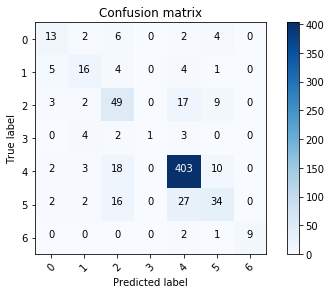

In [47]:
import itertools
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

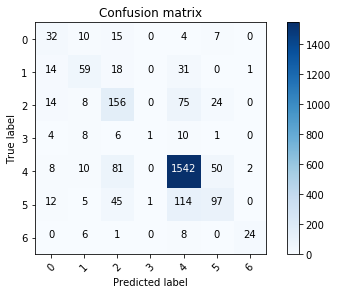

In [48]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

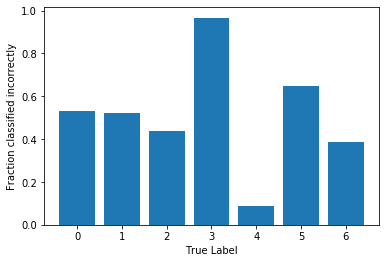

In [49]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

[0.6757870316505432, 0.6764463782310486, 0.6881489753723145, 0.6911158561706543, 0.7023240327835083, 0.7062798738479614, 0.714026689529419, 0.7188066840171814, 0.7258941531181335, 0.7257293462753296, 0.7290259003639221, 0.7351244688034058, 0.7441898584365845, 0.7374320030212402, 0.7464974522590637, 0.7479808926582336, 0.7410581707954407, 0.7436953783035278, 0.7610021233558655, 0.7623207569122314, 0.7710565328598022, 0.7717158198356628, 0.7720454931259155, 0.7751771807670593, 0.7791330218315125, 0.7690786123275757, 0.7731992602348328, 0.7784737348556519, 0.7784737348556519, 0.7844074368476868, 0.7905060052871704, 0.7928135991096497, 0.7903411984443665, 0.7964397668838501, 0.796769380569458, 0.8017141819000244, 0.7992417812347412, 0.7928135991096497, 0.8046810626983643, 0.8007252216339111, 0.8061645030975342, 0.8088017106056213, 0.8074830770492554, 0.8048458695411682, 0.8043513894081116, 0.8025383353233337, 0.8040217757225037, 0.8124278783798218, 0.807977557182312, 0.8116037845611572, 0.

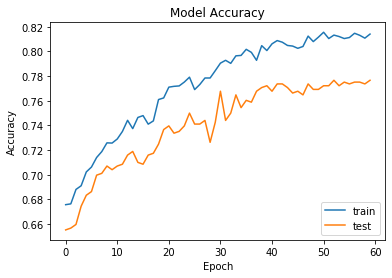

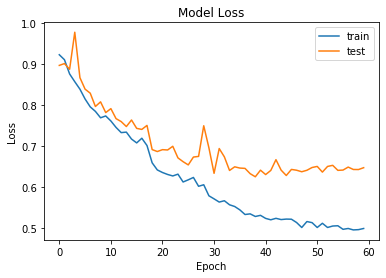

In [81]:
print(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.title("Model Accuracy")
# plt.legend()
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.title("Model Loss")
plt.show()

Tuning Hyperparameters for CNN

In [20]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (100, 125, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))


model.add(Flatten())
# model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 125, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 125, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 62, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 62, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 62, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 62, 64)        36928     
                                                        

In [21]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001,
                                    beta_1 = 0.9,
                                    beta_2 = 0.999,
                                    epsilon = None, decay = 0.0, amsgrad=False)

In [22]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [23]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

In [32]:
# Fit the model
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

C:\Users\msrip\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
608/608 [==============================] - 282s 462ms/step - loss: 1.0385 - accuracy: 0.6666 - val_loss: 0.9557 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 2/50
608/608 [==============================] - 267s 436ms/step - loss: 0.9399 - accuracy: 0.6723 - val_loss: 1.0264 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 3/50
608/608 [==============================] - 198s 326ms/step - loss: 0.9115 - accuracy: 0.6764 - val_loss: 0.9107 - val_accuracy: 0.6583 - lr: 0.0010
Epoch 4/50
608/608 [==============================] - 199s 327ms/step - loss: 0.9017 - accuracy: 0.6801 - val_loss: 0.9719 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 5/50
608/608 [==============================] - 198s 326ms/step - loss: 0.8814 - accuracy: 0.6857 - val_loss: 0.9261 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 6/50
608/608 [==============================] - 200s 329ms/step - loss: 0.8723 - accuracy: 0.6906 - val_loss: 0.9157 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 7/50
608/608 [==========================

608/608 [==============================] - 207s 340ms/step - loss: 0.7226 - accuracy: 0.7370 - val_loss: 0.8233 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 42/50
608/608 [==============================] - 210s 345ms/step - loss: 0.7200 - accuracy: 0.7318 - val_loss: 0.7495 - val_accuracy: 0.7263 - lr: 0.0010
Epoch 43/50
608/608 [==============================] - 207s 340ms/step - loss: 0.7150 - accuracy: 0.7463 - val_loss: 0.7966 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 44/50
608/608 [==============================] - 207s 340ms/step - loss: 0.7179 - accuracy: 0.7398 - val_loss: 0.7914 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 45/50
608/608 [==============================] - 210s 345ms/step - loss: 0.7157 - accuracy: 0.7329 - val_loss: 0.8464 - val_accuracy: 0.6879 - lr: 0.0010
Epoch 46/50
608/608 [==============================] - 219s 361ms/step - loss: 0.7154 - accuracy: 0.7438 - val_loss: 0.7957 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 47/50
608/608 [==============================]

In [33]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("cnn_dec4_model.h5")

22/22 [==============================] - 4s 189ms/step - loss: 0.7863 - accuracy: 0.7189
Validation: accuracy = 0.718935  ;  loss_v = 0.786255
Test: accuracy = 0.714856  ;  loss = 0.776808


In [41]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

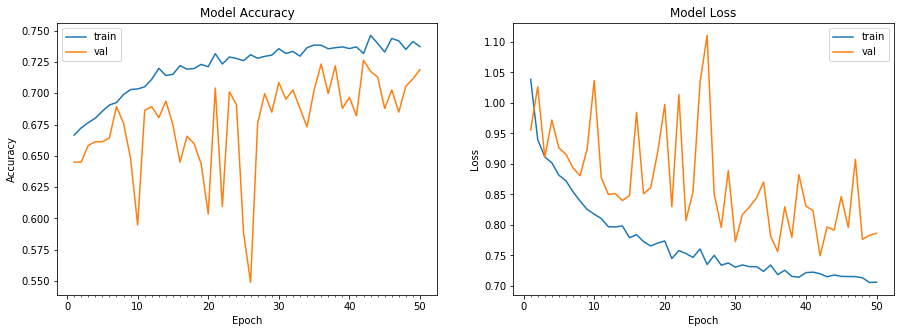

In [42]:
plot_model_history(history)

Transfer Learning - MobileNet

In [95]:
# See the image size distribution - should just return one row (all images are uniform)
df['image'].map(lambda x: x.shape).value_counts()

(224, 224, 3)    10015
Name: image, dtype: int64

Transfer Learning with Mobilenet


In [96]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [97]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [103]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [104]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [105]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0])>)

In [106]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

MemoryError: Unable to allocate 8.42 GiB for an array with shape (7511, 224, 224, 3) and data type float64

In [55]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [102]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(224, 224, 3))
x_test = x_test.reshape(x_test.shape[0], *(224, 224, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(224, 224, 3))

ValueError: Found input variables with inconsistent numbers of samples: [7511, 3590]

In [57]:
print(x_train.shape)


(6759, 100, 125, 3)


In [58]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()


In [59]:
mobile.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [60]:
def change_model(model, new_input_shape=(None, 40, 40, 3),custom_objects=None):
    # replace input shape of first layer
    
    config = model.layers[0].get_config()
    config['batch_input_shape']=new_input_shape
    model.layers[0]=model.layers[0].from_config(config)

    # rebuild model architecture by exporting and importing via json
    new_model = tensorflow.keras.models.model_from_json(model.to_json(),custom_objects=custom_objects)

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [61]:
new_model = change_model(mobile, new_input_shape=[None] + [100,125,3])
new_model.summary()

Loaded layer input_1
Loaded layer conv1
Loaded layer conv1_bn
Loaded layer conv1_relu
Loaded layer conv_dw_1
Loaded layer conv_dw_1_bn
Loaded layer conv_dw_1_relu
Loaded layer conv_pw_1
Loaded layer conv_pw_1_bn
Loaded layer conv_pw_1_relu
Loaded layer conv_pad_2
Loaded layer conv_dw_2
Loaded layer conv_dw_2_bn
Loaded layer conv_dw_2_relu
Loaded layer conv_pw_2
Loaded layer conv_pw_2_bn
Loaded layer conv_pw_2_relu
Loaded layer conv_dw_3
Loaded layer conv_dw_3_bn
Loaded layer conv_dw_3_relu
Loaded layer conv_pw_3
Loaded layer conv_pw_3_bn
Loaded layer conv_pw_3_relu
Loaded layer conv_pad_4
Loaded layer conv_dw_4
Loaded layer conv_dw_4_bn
Loaded layer conv_dw_4_relu
Loaded layer conv_pw_4
Loaded layer conv_pw_4_bn
Loaded layer conv_pw_4_relu
Loaded layer conv_dw_5
Loaded layer conv_dw_5_bn
Loaded layer conv_dw_5_relu
Loaded layer conv_pw_5
Loaded layer conv_pw_5_bn
Loaded layer conv_pw_5_relu
Loaded layer conv_pad_6
Loaded layer conv_dw_6
Loaded layer conv_dw_6_bn
Loaded layer conv_dw_6_

In [62]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = new_model.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=new_model.input, outputs=predictions)

In [63]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [64]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [65]:
from tensorflow.keras.optimizers import Adam


In [66]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

C:\Users\msrip\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [67]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [69]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


In [70]:
batch_size = 16


In [71]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), 
                              class_weight=class_weights,
                    validation_data=(x_validate,y_validate),steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=10, verbose=1,
                   callbacks=callbacks_list)

C:\Users\msrip\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/10


ValueError: in user code:

    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 810, in train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\losses.py", line 1665, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, 7, 7, 7) are incompatible


MobileNet

In [26]:
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [27]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()


In [28]:
mobile.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [29]:
type(mobile.layers)


list

In [30]:
len(mobile.layers)


91

In [31]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [32]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [33]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

In [34]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [35]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

C:\Users\msrip\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [47]:
filepath = "mobile_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

batch_size = 10

train_steps = x_train.shape[0] // batch_size
val_steps = x_validate.shape[0] // batch_size
print(x_train.shape)

history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size), steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=(x_validate,y_validate),
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

(5474, 100, 125, 3)


C:\Users\msrip\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30


ValueError: in user code:

    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\training.py", line 810, in train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\losses.py", line 1665, in categorical_crossentropy
        y_true, y_pred, from_logits=from_logits, axis=axis)
    File "C:\Users\msrip\anaconda3\lib\site-packages\keras\backend.py", line 4994, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, None) and (None, 7, 7, 7) are incompatible


XCeption

In [50]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline

In [68]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
tf.unique(x_train_o.cell_type.values)

Unique(y=<tf.Tensor: shape=(7,), dtype=string, numpy=
array([b'Melanocytic nevi', b'Basal cell carcinoma', b'Melanoma',
       b'Vascular lesions', b'Benign keratosis-like lesions ',
       b'Actinic keratoses', b'Dermatofibroma'], dtype=object)>, idx=<tf.Tensor: shape=(7511,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 0])>)

In [80]:
x_train_o.shape

(7511, 10)

In [70]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [71]:
print(x_train.shape)

(7511, 100, 125, 3)


ResNet50

In [78]:
import keras
# from keras_applications.resnext import ResNeXt50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras import backend as K 

In [83]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=False,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

ValueError: Data cardinality is ambiguous:
  x sizes: 6008
  y sizes: 3590
Make sure all arrays contain the same number of samples.